## 3.1. Event-Related Potential (ERP) Analysis

1. What Event-Related Potentials (ERPs) are and why they matter
2. How to segment continuous EEG data into epochs
3. How to compute ERPs by averaging epochs
4. How to identify and measure ERP components (P100, N170, P300)
5. How to compare ERPs between conditions
6. How to perform statistical testing on ERP data

**Event-Related Potentials (ERPs)** are time-locked electrical brain responses to specific events (stimuli, responses, or cognitive processes).


**Key Concepts**:
- **Epoching**: Cutting continuous EEG into time-locked segments around events.
- **Averaging**: Computing the mean across trials to increase signal-to-noise ratio.
- **Components**: Characteristic peaks in the ERP waveform.
  - **P1 (~100ms)**: Early visual processing
  - **N170 (~170ms)**: Face/object recognition
  - **P300 (~300ms)**: Attention and memory updating

**Why Average?**
Single trials contain both **signal** (brain response) and **noise** (random EEG activity).
- **Signal**: Consistent across trials (time-locked to event)
- **Noise**: Random and cancels out when averaging
- **Result**: SNR improves by √n (n = number of trials)

In [1]:
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats

# Setup plotting backend
%matplotlib inline
mne.set_config('MNE_BROWSER_BACKEND', 'matplotlib', set_env=True)

Using matplotlib as 2D backend.


In [2]:
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
mne.set_log_level('WARNING')

### 1. Load the Data
We'll use the MNE sample dataset, which contains MEG/EEG data from an auditory-visual experiment.

In [3]:
# Using the MNE sample dataset directly
data_path = mne.datasets.sample.data_path()
raw_fname = data_path / "MEG" / "sample" / "sample_audvis_raw.fif"
raw = mne.io.read_raw_fif(raw_fname, preload=True)

In [4]:
# Keep only EEG channels for this analysis
raw.pick_types(meg=False, eeg=True, eog=True, stim=True)

print(f"Data Info:")
print(f"  Channels: {len(raw.ch_names)} EEG channels")
print(f"  Sampling rate: {raw.info['sfreq']} Hz")
print(f"  Duration: {raw.times[-1]:.1f} seconds")

Data Info:
  Channels: 69 EEG channels
  Sampling rate: 600.614990234375 Hz
  Duration: 277.7 seconds


### 2. Preprocessing
- Apply Band-pass filter (1-40 Hz) to remove slow drifts and high-frequency noise
- Apply Notch filter at 60Hz to remove line noise
- Set EEG reference to average

In [5]:
raw.filter(l_freq=1.0, h_freq=40.0)
raw.notch_filter(freqs=60.0)
raw.set_eeg_reference('average', projection=True)

<Raw | sample_audvis_raw.fif, 69 x 166800 (277.7 s), ~90.8 MiB, data loaded>

### 3. Extract Events for Epoching

Events mark when something happened in the experiment (stimulus presentation, button press, etc.).

In MNE, events are stored as a numpy array with shape `(n_events, 3)`:
- Column 0: Sample number (when event occurred)
- Column 1: Previous event value (usually 0)
- Column 2: Event ID (what type of event)


In [6]:
events = mne.find_events(raw, stim_channel='STI 014')
print(f"Found {len(events)} events")
print(f"\nFirst 5 events:")
print(events[:5])

Found 320 events

First 5 events:
[[27977     0     2]
 [28345     0     3]
 [28771     0     1]
 [29219     0     4]
 [29652     0     2]]


In [7]:
# Define event IDs (Mapping from the sample dataset)
event_id = {
    'Auditory/Left': 1, 
    'Auditory/Right': 2, 
    'Visual/Left': 3, 
    'Visual/Right': 4
}

In [8]:
# Count events per condition
print(f"Events per condition:")
for name, id in event_id.items():
    count = np.sum(events[:, 2] == id)
    print(f"  {name}: {count} trials")

Events per condition:
  Auditory/Left: 72 trials
  Auditory/Right: 73 trials
  Visual/Left: 73 trials
  Visual/Right: 71 trials


/var/folders/4w/jb7nh9ns51vcx_1p3nn151800000gn/T/ipykernel_20409/65730152.py:2: RuntimeWarning: event 5 missing from event_id will be ignored
  mne.viz.plot_events(
/var/folders/4w/jb7nh9ns51vcx_1p3nn151800000gn/T/ipykernel_20409/65730152.py:2: RuntimeWarning: event 32 missing from event_id will be ignored
  mne.viz.plot_events(
/var/folders/4w/jb7nh9ns51vcx_1p3nn151800000gn/T/ipykernel_20409/65730152.py:11: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


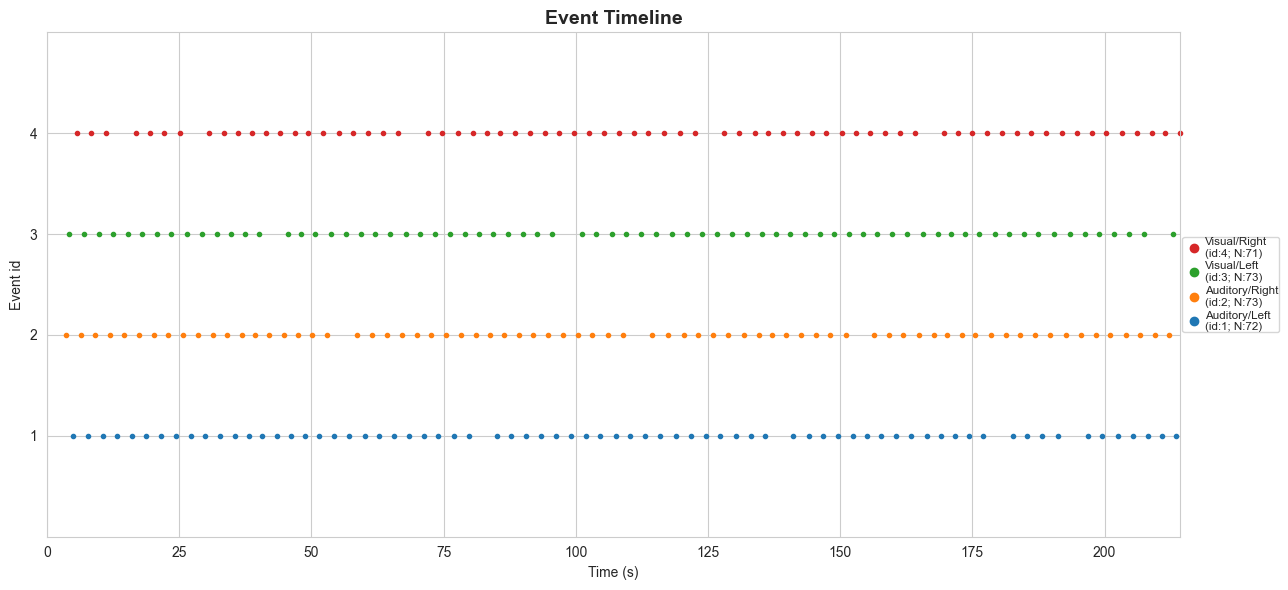

In [9]:
# Visualize events
mne.viz.plot_events(
    events,
    sfreq=raw.info['sfreq'],
    event_id=event_id,
    first_samp=raw.first_samp,
    show=False
)

plt.title('Event Timeline', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

###  4. Create Epochs

**Epoching** segments continuous data into time-locked trials.

Key Parameters:
- `tmin, tmax`: Time window around event 
- `baseline`: Period for baseline correction 
- `reject`: Amplitude thresholds to reject bad trials

**Baseline Correction**: Removes pre-stimulus activity by subtracting the mean of the baseline period. This makes the signal relative to a zero baseline, allowing comparison across trials.

In [10]:
tmin, tmax = -0.2, 0.5  # Time window: 200ms pre-stim to 500ms post-stim
baseline = (-0.2, 0)    # Baseline correction window
reject = dict(eeg=100e-6) # Reject trials with amplitude > 100 µV

epochs = mne.Epochs(
    raw, 
    events, 
    event_id, 
    tmin, 
    tmax, 
    baseline=baseline,
    reject=reject, 
    preload=True
)

print(f"\n✓ Created {len(epochs)} good epochs")
print(f"  Dropped: {epochs.drop_log_stats()}% of epochs")
print(f"  Time window: {epochs.tmin:.2f} to {epochs.tmax:.2f} seconds")
print(f"  Baseline: {epochs.baseline}")


✓ Created 257 good epochs
  Dropped: 11.072664359861593% of epochs
  Time window: -0.20 to 0.50 seconds
  Baseline: (-0.2, 0.0)


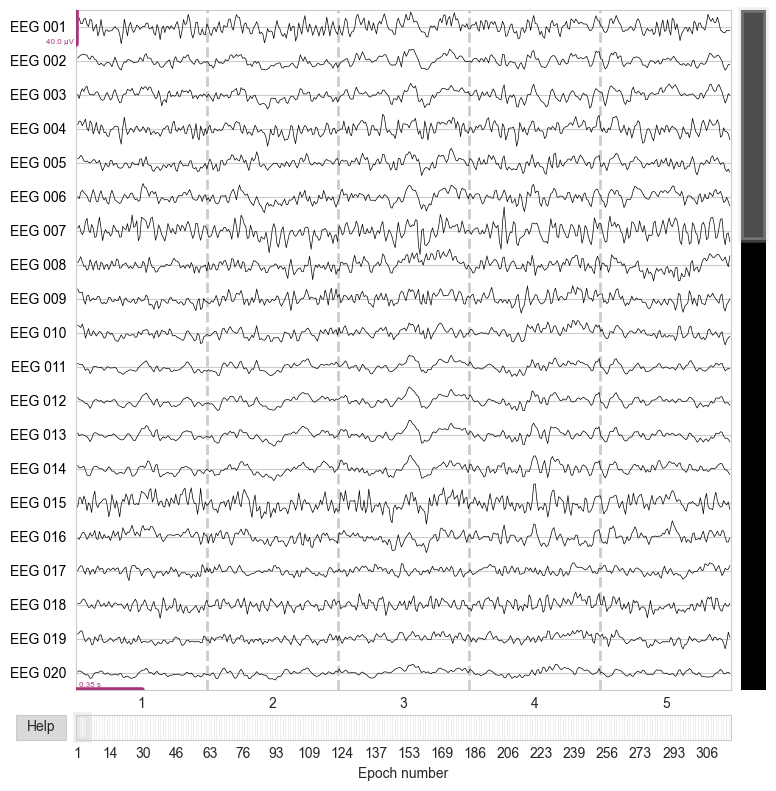

In [11]:
# Visualize epochs
epochs.plot(n_epochs=5, n_channels=20, title='Epoch Browser')
plt.show()

### 5. Compute ERPs by Averaging

The ERP is the **average** of all epochs in a condition.

**Mathematical Formula:** 

$ERP(t) = \frac{1}{N} \sum_{i=1}^{N} x_i(t)$

Where:
- $N$ = number of trials
- $x_i(t)$ = signal at time $t$ for trial $i$

**Signal-to-Noise Ratio (SNR)**:
- Single trial SNR: 1:1 (signal buried in noise)
- After averaging N trials: SNR improves by $\sqrt{N}$
- Example: 100 trials → SNR improved by 10×

In [12]:
# Average trials for Auditory vs Visual conditions
evoked_auditory = epochs['Auditory'].average()
evoked_visual = epochs['Visual'].average()

**Why Pz?**
- Pz is a **midline parietal electrode**
- Commonly associated with:
  - Auditory attention
  - Cognitive evaluation of sounds


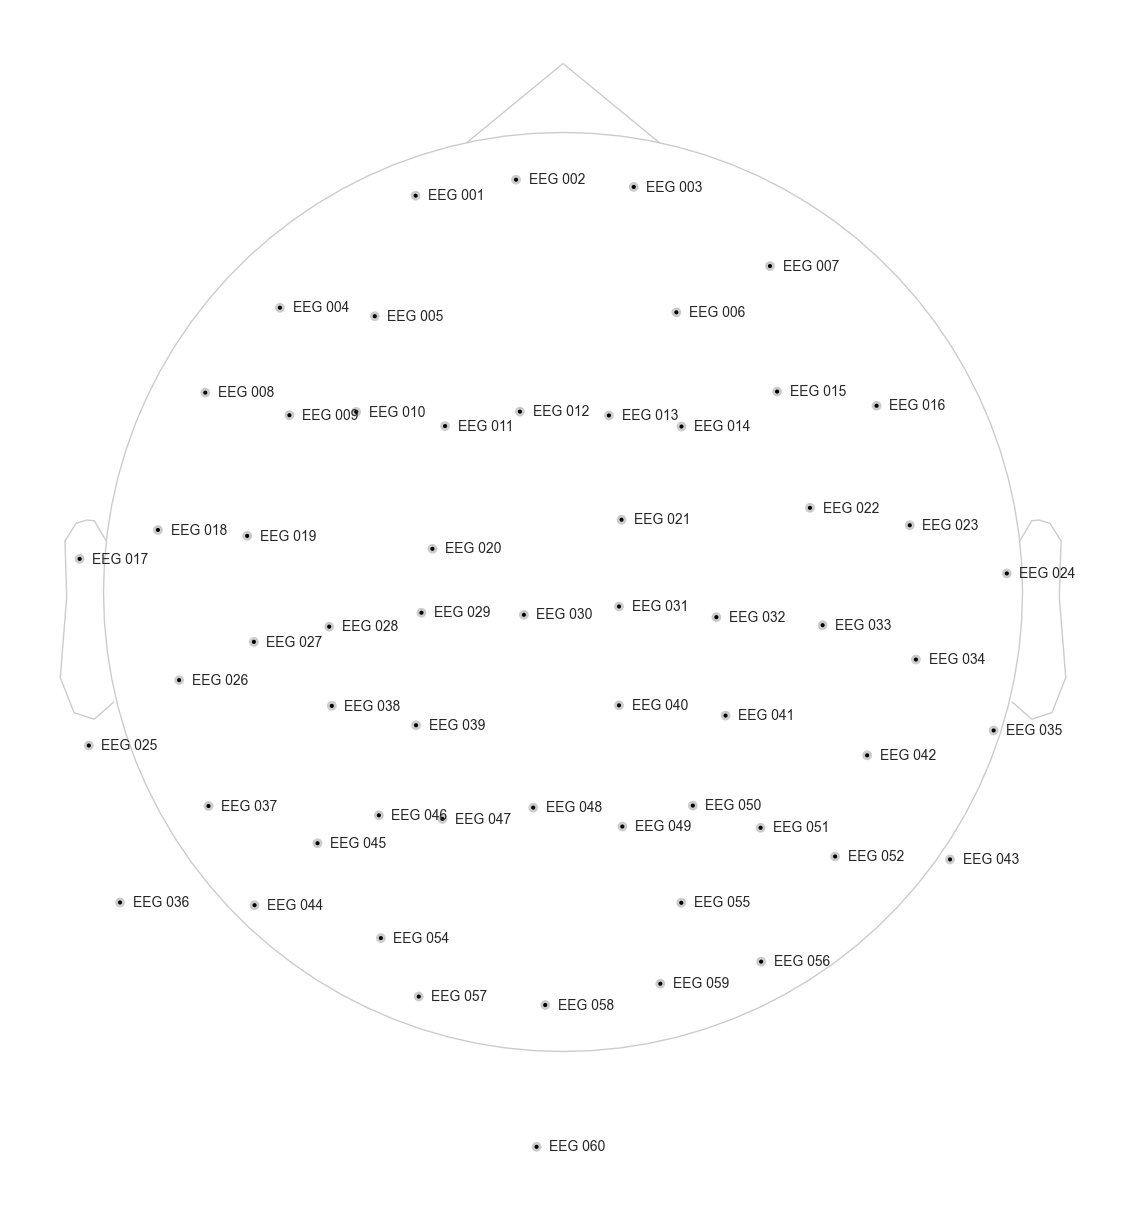

In [13]:
evoked_auditory.plot_sensors(show_names=True)
plt.show()

**Why Oz?**
- Oz sits over **primary visual cortex (occipital lobe)**
- Optimal for detecting early visual responses

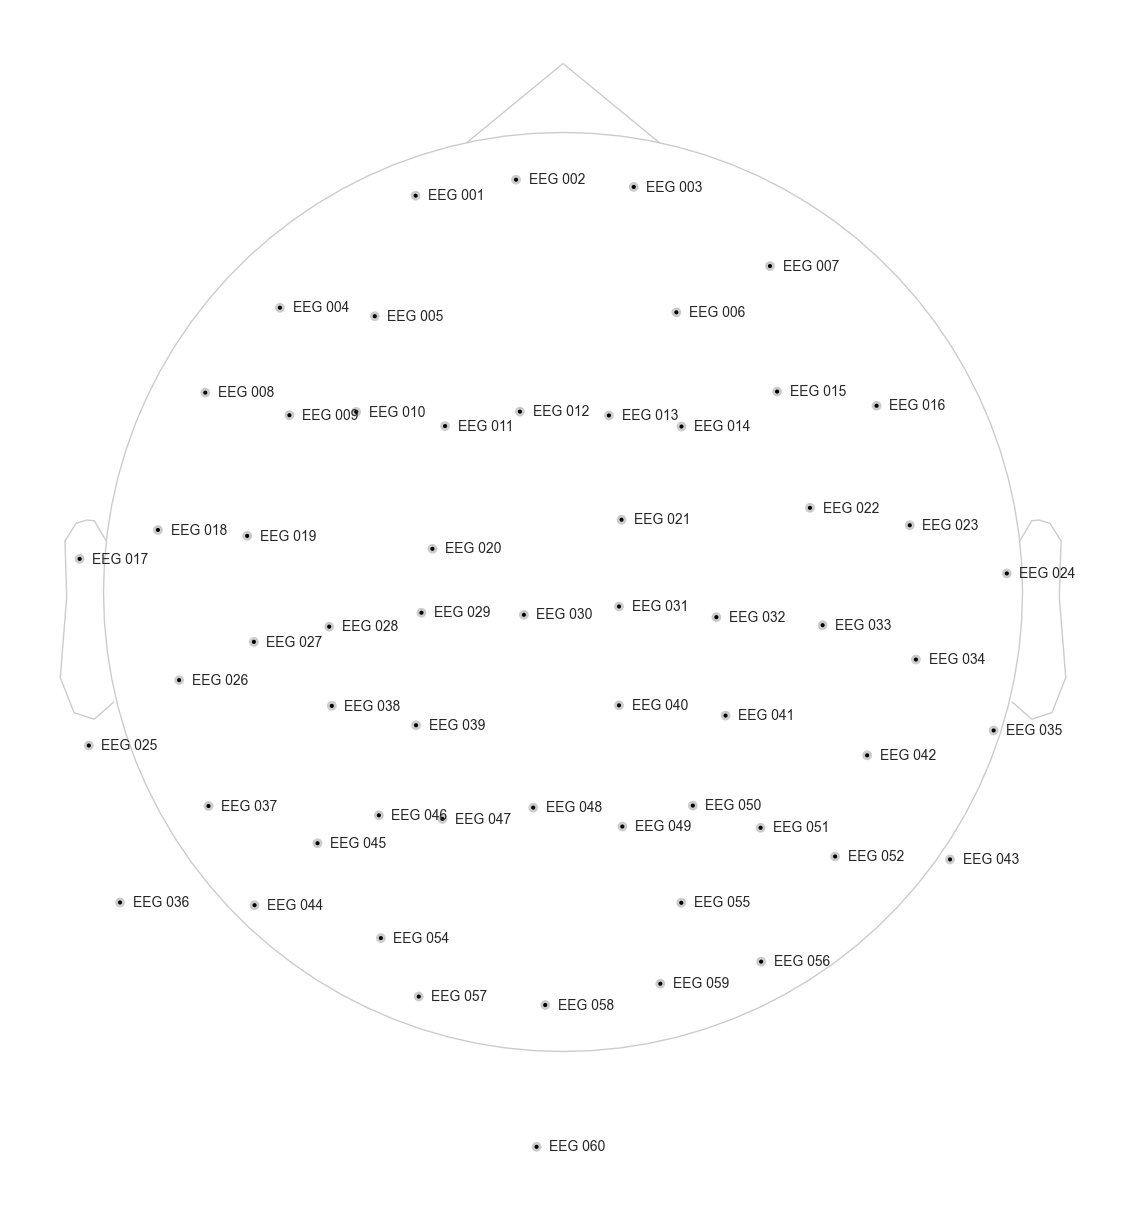

In [14]:
evoked_auditory.plot_sensors(show_names=True)
plt.show()

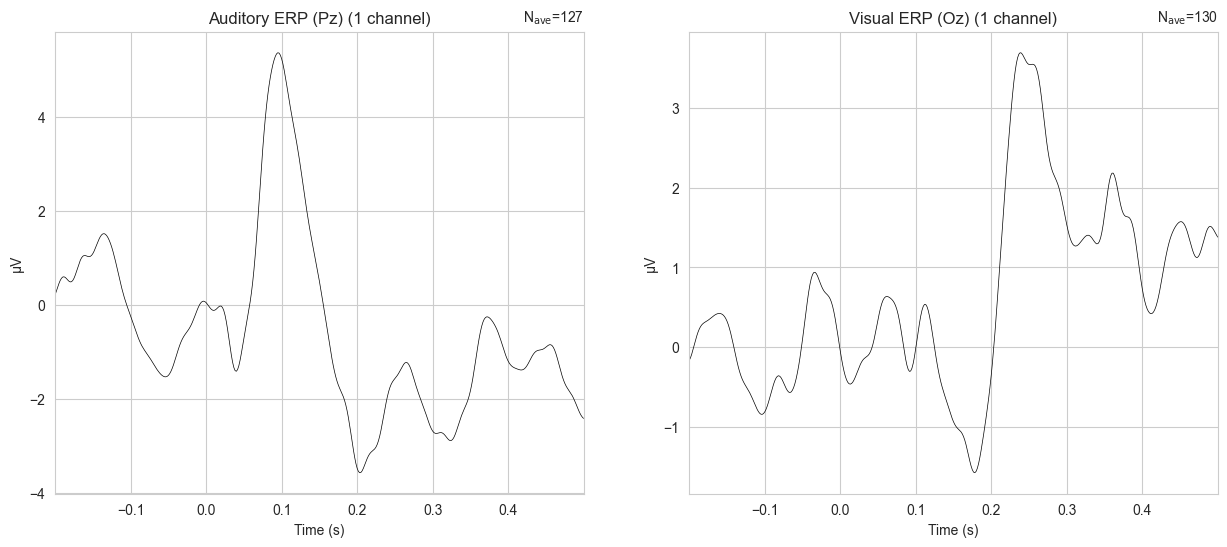

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Plot Auditory ERP at electrode Pz (common for auditory/attention)
evoked_auditory.plot(
    picks='EEG 058',
    axes=ax[0],
    titles='Auditory ERP (Pz)',
    show=False
)

# Plot Visual ERP at electrode Oz (visual processing)
evoked_visual.plot(
    picks='EEG 060',
    axes=ax[1],
    titles='Visual ERP (Oz)',
    show=False
)

plt.show()

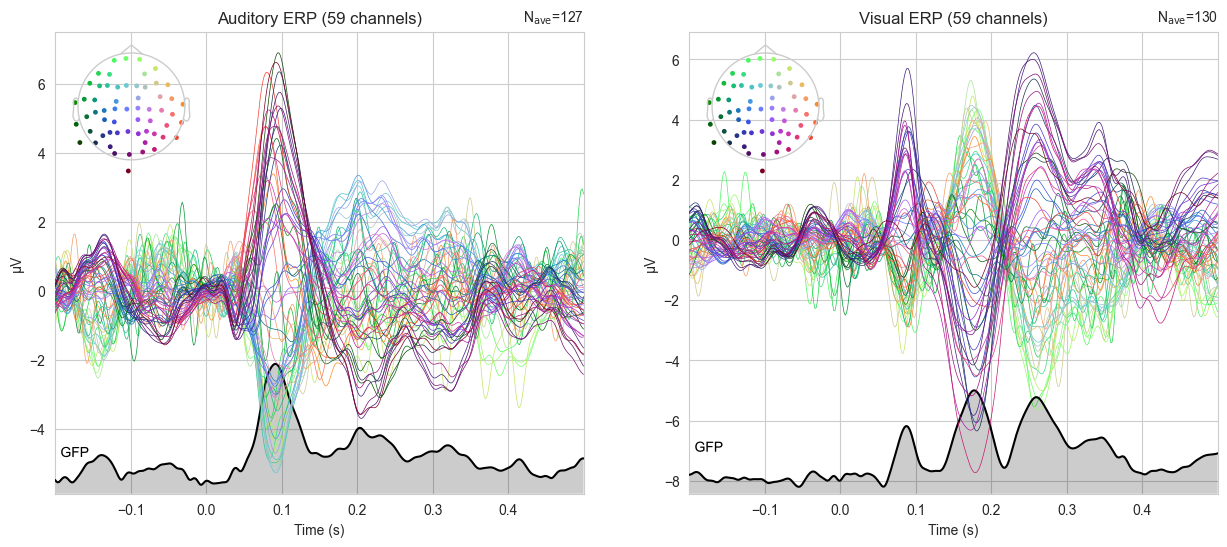

In [16]:
# Visualize auditory and visual  ERP
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Plot Auditory ERP 
evoked_auditory.plot(
    axes=ax[0],
    titles='Auditory ERP',
    spatial_colors=True,
    gfp=True,
    show=False
)

# Plot Visual ERP
evoked_visual.plot(
    axes=ax[1],
    titles='Visual ERP',
    spatial_colors=True,
    gfp=True,
    show=False
)

plt.show()

### 6. ERP Comparison
Comparing ERPs between conditions reveals which brain regions respond differently.


Comparing auditory vs visual ERPs...


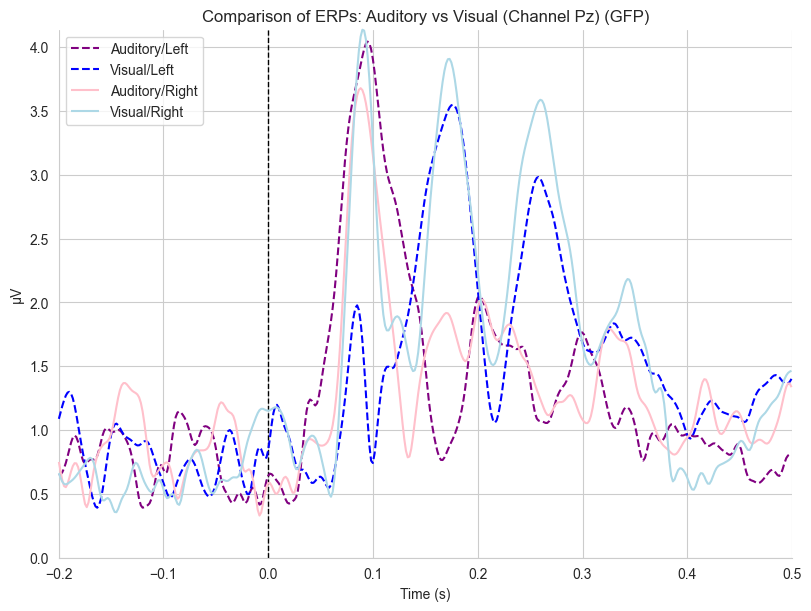

In [17]:
# Compare auditory vs visual ERPs
conditions_to_compare = ['Auditory/Left', 'Visual/Left', 'Auditory/Right', 'Visual/Right']
evoked_dict = {cond: epochs[cond].average() for cond in conditions_to_compare}
print("Comparing auditory vs visual ERPs...")

fig = mne.viz.plot_compare_evokeds(
    evoked_dict,
    colors=dict(zip(conditions_to_compare, ['purple', 'blue', 'pink', 'lightblue'])),
    linestyles={'Auditory/Left': '--', 'Visual/Left': '--', 'Auditory/Right': '-', 'Visual/Right': '-'},
    title='Comparison of ERPs: Auditory vs Visual (Channel Pz)',
    show=False
)

plt.show()

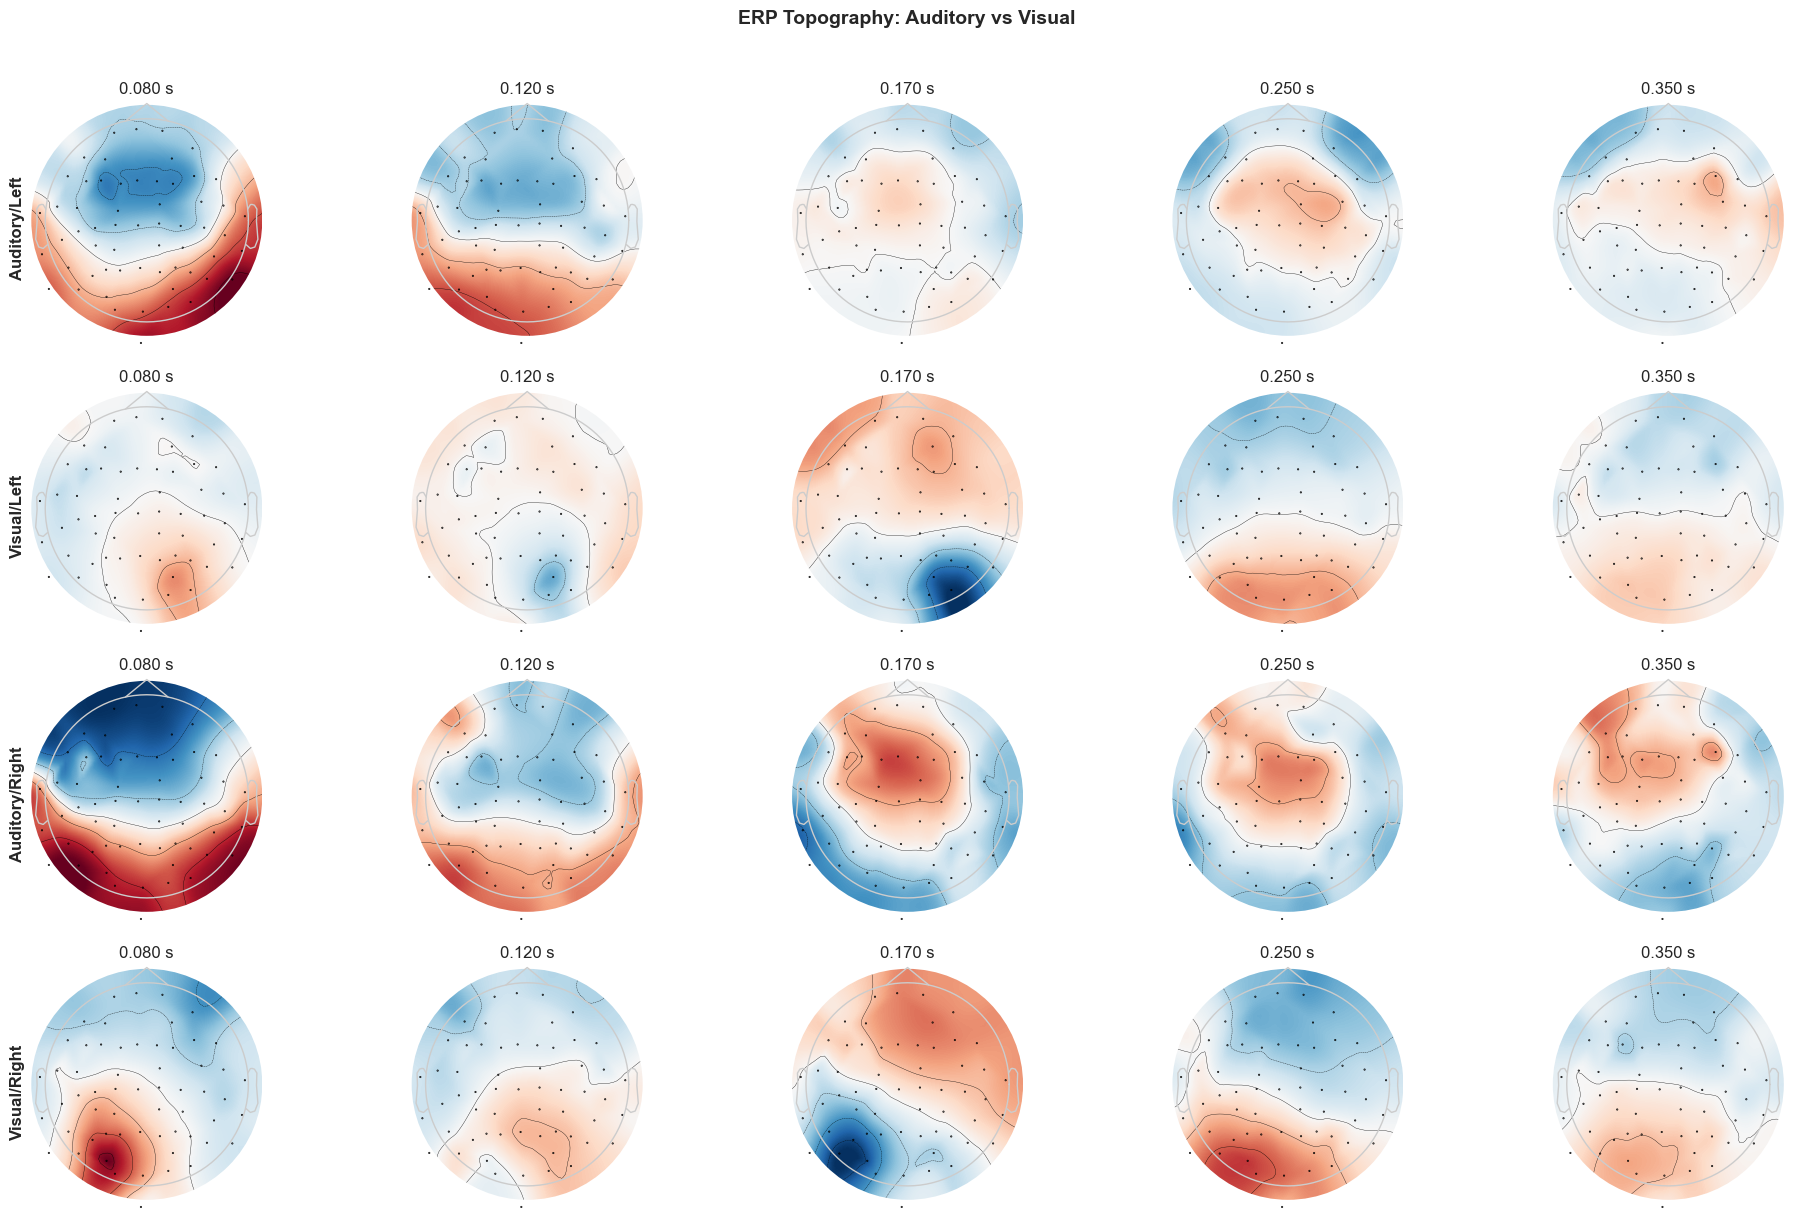

In [18]:
# Plot topographic maps at different time points
times = np.array([0.08, 0.12, 0.17, 0.25, 0.35])

fig, axes = plt.subplots(4, len(times), figsize=(20, 12))

for idx, condition in enumerate(conditions_to_compare):
    evoked_dict[condition].plot_topomap(
        times=times,
        axes=axes[idx],
        colorbar=False,
        show=False
    )
    axes[idx, 0].set_ylabel(condition, fontsize=12, fontweight='bold')

plt.suptitle('ERP Topography: Auditory vs Visual', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

**Difference waves** (Contrasts) isolate brain activity unique to one condition.

Formula:
$Contrast = ERP_A - ERP_B$

Example:
- Visual - Auditory = **Visual-specific** processing
- Target - Standard = **Oddball effect** (P300)

Difference waves remove shared activity (e.g., attention, motor prep) and highlight condition-specific responses.

Computing difference wave: Visual - Auditory



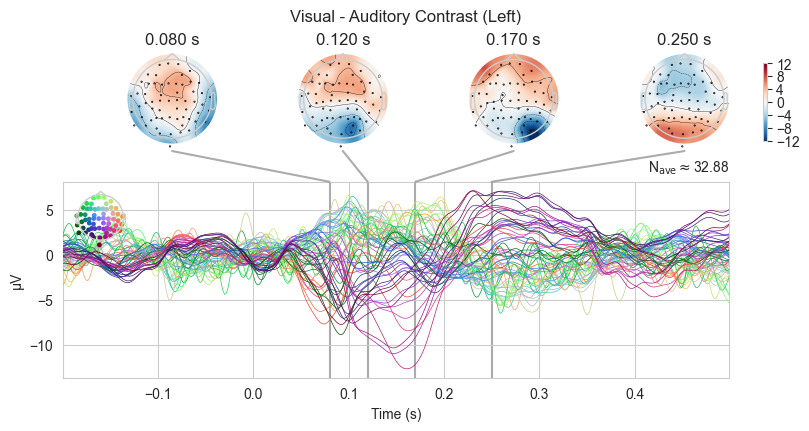

In [19]:
# Compute contrast: Visual - Auditory (Left)
print("Computing difference wave: Visual - Auditory\n")
contrast_left = mne.combine_evoked([evoked_dict['Visual/Left'], evoked_dict['Auditory/Left']], weights=[1, -1])

# Visualize the contrast
contrast_left.plot_joint(
    times=[0.08, 0.12, 0.17, 0.25],
    title='Visual - Auditory Contrast (Left)'
)
plt.show()

Computing difference wave: Visual - Auditory



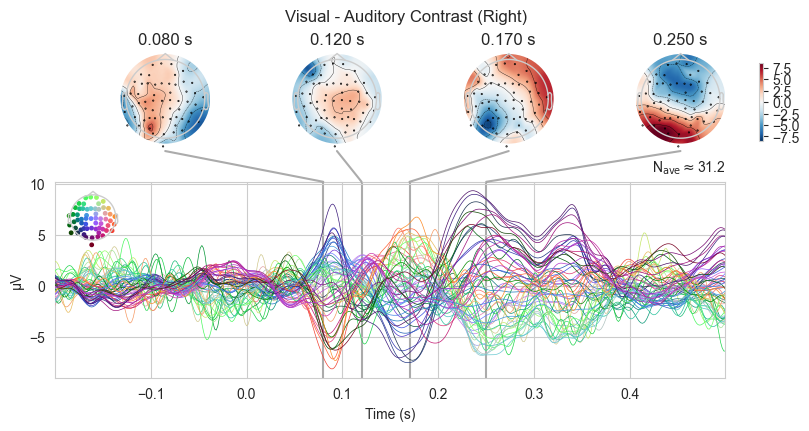

In [20]:
# Compute contrast: Visual - Auditory (Right)
print("Computing difference wave: Visual - Auditory\n")
contrast_right = mne.combine_evoked([evoked_dict['Visual/Right'], evoked_dict['Auditory/Right']], weights=[1, -1])

# Visualize the contrast
contrast_right.plot_joint(
    times=[0.08, 0.12, 0.17, 0.25],
    title='Visual - Auditory Contrast (Right)'
)
plt.show()

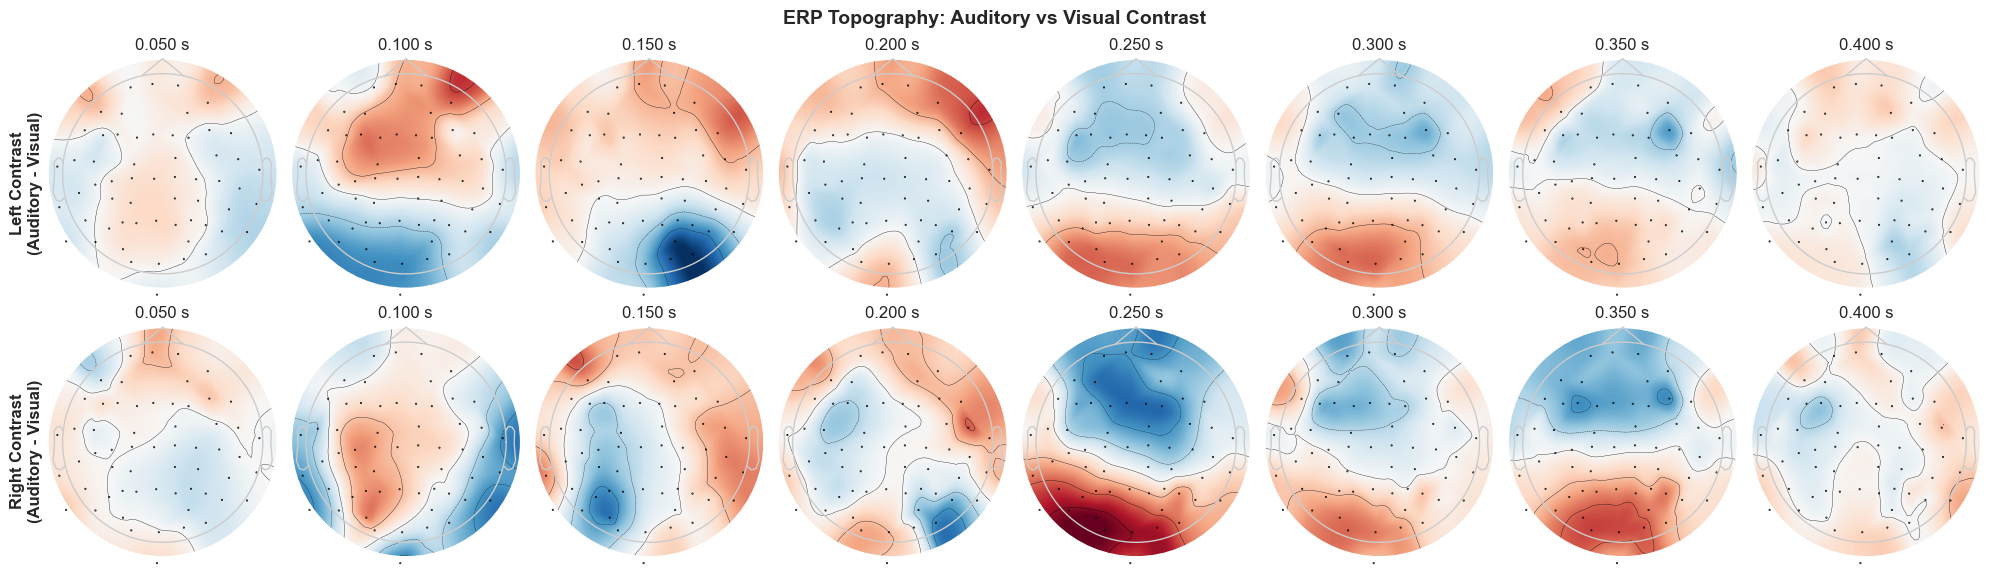

In [22]:
times = np.linspace(0.05, 0.4, 8)

fig, axes = plt.subplots(2, len(times), figsize=(20, 6))

contrast_left.plot_topomap(
    times=times, 
    ch_type='eeg', 
    axes=axes[0],
    colorbar=False,
    show=False
)

contrast_right.plot_topomap(
    times=times, 
    ch_type='eeg', 
    axes=axes[1],
    colorbar=False,
    show=False
)

axes[0, 0].set_ylabel('Left Contrast\n(Auditory - Visual)', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Right Contrast\n(Auditory - Visual)', fontsize=12, fontweight='bold')

plt.suptitle('ERP Topography: Auditory vs Visual Contrast', fontsize=14, fontweight='bold', y=0.98)
plt.tight_layout()

plt.show()


### 7. Feature Extraction: ERP Components

**ERP Components** are characteristic peaks with known functional significance:

Common Visual ERP Components:
- **P1 (80-120ms)**: Early visual processing in occipital cortex
- **N170 (150-200ms)**: Face/object recognition in temporal cortex
- **P300 (250-500ms)**: Attention, memory updating, decision making

Measurement:
- **Latency**: Time of peak (milliseconds)
- **Amplitude**: Size of peak (microvolts)
- **Topography**: Spatial distribution (which electrodes show it)

In [23]:
# Define components to measure
time_windows = {
    'P1': (0.08, 0.12),
    'N170': (0.13, 0.20),
    'P300': (0.25, 0.45)
}

In [24]:
features = []
channels_of_interest = ['EEG 058', 'EEG 059', 'EEG 060']

In [25]:
for window_name, (t_start, t_end) in time_windows.items():
    mask = (evoked_visual.times >= t_start) & (evoked_visual.times <= t_end)
    
    for ch in channels_of_interest:
        ch_idx = evoked_visual.ch_names.index(ch)
        data = evoked_visual.data[ch_idx, mask]
        
        features.append({
            'Component': window_name,
            'Channel': ch,
            'Mean_Amplitude': np.mean(data),
            'Peak_Latency': evoked_visual.times[mask][np.argmax(np.abs(data))]
        })

feature_df = pd.DataFrame(features)
print("\nExtracted ERP Features:")
display(feature_df)


Extracted ERP Features:


,Component,Channel,Mean_Amplitude,Peak_Latency
0,P1,EEG 058,1.053820e-06,0.084913
1,P1,EEG 059,1.123815e-06,0.084913
2,P1,EEG 060,1.225383e-07,0.111552
3,N170,EEG 058,-2.215236e-06,0.173156
4,N170,EEG 059,-4.044231e-06,0.173156
5,N170,EEG 060,-1.014043e-06,0.178151
6,P300,EEG 058,2.408023e-06,0.258069
7,P300,EEG 059,1.367034e-06,0.259734
8,P300,EEG 060,1.636322e-06,0.254739


### 8. Statistical Testing

We test if there is a significant difference between ALL Auditory vs ALL Visual trials

When you compare two ERP conditions, you aren't just comparing two numbers; you are comparing two **continuous series of data points** over time. If you performed a standard t-test at every single millisecond, you would run into the **"Multiple Comparisons Problem"**—the more tests you run, the higher the chance of finding a "significant" result purely by accident.

The Cluster-based Permutation Test solves this in three steps:
1. **Mass Univariate Testing**: It calculates a t-statistic for every single time point in your window.
2. **Clustering**: It looks for contiguous time points where the t-statistic exceeds a certain threshold. These "clumps" of significant points are called **Clusters**. Each cluster gets a "Cluster Mass Score" based on its size and strength.
3. **Permutation**: It shuffles (permutes) the labels of your data thousands of times. It calculates the largest cluster score for each shuffle to build a distribution of what "random luck" looks like. It then compares your real cluster score to this random distribution to calculate a p-value.

In [26]:
# Extract trial data for posterior electrodes where visual and auditory ERPs are typically strongest.
roi_channels = ['EEG 057', 'EEG 058', 'EEG 059', 'EEG 060']
picks_idx = [raw.ch_names.index(ch) for ch in roi_channels]

# We average across the selected channels to create a "virtual ROI channel"
data_aud = epochs['Auditory'].get_data(picks=roi_channels).mean(axis=1)
data_vis = epochs['Visual'].get_data(picks=roi_channels).mean(axis=1)

In [27]:
# Perform the permutation cluster test
print("\nRunning Cluster-based Permutation Test across Posterior Channels...")

# This identifies time-periods where the two conditions significantly differ
t_obs, clusters, cluster_pv, H0 = mne.stats.permutation_cluster_test(
    [data_aud, data_vis], 
    n_permutations=1000, 
    tail=0,
    threshold=None # Automatically determines a t-threshold
)


Running Cluster-based Permutation Test across Posterior Channels...


/var/folders/4w/jb7nh9ns51vcx_1p3nn151800000gn/T/ipykernel_20409/1636884412.py:5: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  t_obs, clusters, cluster_pv, H0 = mne.stats.permutation_cluster_test(


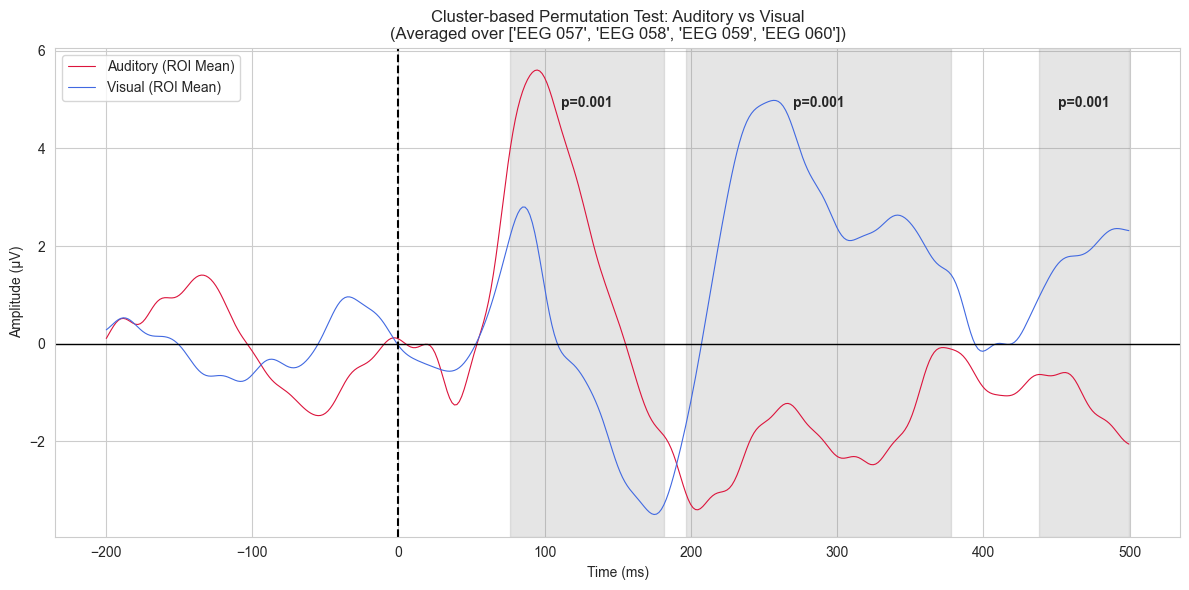

In [28]:
times = epochs.times * 1000  # Convert to ms for plotting
plt.figure(figsize=(12, 6))

# Plot the means
plt.plot(times, data_aud.mean(axis=0) * 1e6, label='Auditory (ROI Mean)', color='crimson', lw=0.8)
plt.plot(times, data_vis.mean(axis=0) * 1e6, label='Visual (ROI Mean)', color='royalblue', lw=0.8)

# Highlight significant clusters
for i, p_val in enumerate(cluster_pv):
    if p_val < 0.05:
        t_start = times[clusters[i][0][0]]
        t_end = times[clusters[i][0][-1]]
        
        plt.axvspan(t_start, t_end, color='gray', alpha=0.2)
        plt.text((t_start + t_end) / 2, plt.ylim()[1] * 0.8, f'p={p_val:.3f}', 
                 horizontalalignment='center', fontweight='bold')

plt.title(f"Cluster-based Permutation Test: Auditory vs Visual\n(Averaged over {roi_channels})")
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude (µV)")
plt.axvline(0, color='black', linestyle='--') # Stimulus onset
plt.axhline(0, color='black', lw=1)
plt.legend()
plt.tight_layout()
plt.show()

**(Significant Clusters)**
- **Presence of Shading**: If you see gray shaded regions, those are time windows where the difference between conditions is statistically significant (usually $p < 0.05$).
- **Timing**: Look at when the shading occurs.
  - Significant shading around **100–150ms** often represents primary sensory differences (the brain processing the physical difference between a sound and a flash).
  - Significant shading around **300ms+** usually represents cognitive differences (attention, memory, or stimulus categorization).

In [29]:
# Report results
print(f"✓ Test complete!\n")
print(f" Statistical Results:")
print(f"  Total clusters found: {len(clusters)}")
print(f"  Significant clusters (p < 0.05): {np.sum(cluster_pv < 0.05)}\n")

✓ Test complete!

 Statistical Results:
  Total clusters found: 5
  Significant clusters (p < 0.05): 3



### Summary
- ERPs require many trials (20-100+) for good SNR  
- Baseline correction removes pre-stimulus differences  
- Component measurement requires careful time window selection  
- Statistical testing must account for multiple comparisons  